# Table of Contents
* [Introduction](#Introduction)
	* [Guiding questions](#Guiding-questions)
	* [Related notebooks](#Related-notebooks)
* [Setup](#Setup)
	* [Imports](#Imports)
	* [Load data](#Load-data)
	* [code](#code)
	* [load](#load)
* [Analysis](#Analysis)
	* [code](#code)
	* [run](#run)
* [Conclusions](#Conclusions)
	* [Key findings](#Key-findings)
	* [Next steps](#Next-steps)


# Introduction

## Guiding questions

* Guiding question:
Can I improve grid extraction by finding largest component first, then extracting contours

## Related notebooks

* **Related notebooks:**  early_table_parse_experiment.ipynb

# Setup

## Imports

In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
import hashlib
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import os
import cv2

import PIL.Image as Image
import skimage.filters

from urllib.request import url2pathname

In [4]:
%load_ext version_information
%reload_ext version_information
%version_information numpy, matplotlib, pandas, scipy, cv2, skimage, PIL

Software,Version
Python,3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython,6.0.0
OS,Darwin 16.6.0 x86_64 i386 64bit
numpy,1.12.1
matplotlib,2.0.2
pandas,0.20.1
scipy,0.19.0
cv2,3.2.0
skimage,0.13.0
PIL,4.1.1


## Load data 

* **File:**  various image files
* **Description of data:** various image files

## code

In [31]:
# def compute_data_hash(data_path):
#     with open(data_path, 'rb') as f:
#         md5_hash = hashlib.md5(f.read()).hexdigest()
#         print(data_path, md5_hash)
#     return md5_hash

# def compute_and_write_hashes(data_files, json_filename):
#     data_hashes = {dfp: compute_data_hash(dfp) for dfp in data_files}
#     output_dir = 'data_hashes'
#     try:
#         os.mkdir(output_dir)
#     except FileExistsError:
#         pass
    
#     with open(os.path.join(output_dir, json_filename), 'w') as f:
#         json.dump(data_hashes, f)

# %%javascript
# var kernel = IPython.notebook.kernel;
# var window_name = window.location.href;
# var command = "notebook_url = \"" + escape(window_name) + "\""
# kernel.execute(command);

# nb_filename = url2pathname(notebook_url).split('/')[-1]
# if nb_filename.endswith('#'):
#     nb_filename = nb_filename[:-1]
# json_filename = nb_filename.replace('ipynb', 'json')

# compute_and_write_hashes(data_file_paths, json_filename)
# print('on date:')
# !date

## load

# Analysis

## code

In [5]:
def ifa(img_arr):
    return Image.fromarray(img_arr)


def ifb(blobs):
    plt.imshow(blobs, cmap='nipy_spectral')
    _ = plt.axis('off')

    
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)


def draw_detections(img_path, found_cells):    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in found_cells:
        start_x = cell[0][0]
        start_y = cell[0][1]
        end_x = cell[1][0]
        end_y = cell[1][1]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)

In [6]:
def convert_binary_image(binary_image):
    image = binary_image.astype('uint8') * np.ones_like(binary_image) * 255
    return image


def foreground_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_val = skimage.filters.threshold_mean(gray)
    foreground = gray < thresh_val
    return convert_binary_image(foreground)


def connect_and_label_components(foreground_img, n=100, l=256):
    img = skimage.filters.gaussian(foreground_img, sigma=l / (4. * n))
    blobs = img > img.mean()
    labeled_image_components = skimage.measure.label(blobs)
    return labeled_image_components


def find_largest_component(labeled_components):
    regions = skimage.measure.regionprops(labeled_components)
    regions_by_area = sorted(regions, key=lambda x: x.convex_area, reverse=True)
    largest_region = regions_by_area[0]
    return convert_binary_image(labeled_components == largest_region.label)


def cell_from_contour(contour):
    cont = contour.reshape((contour.shape[0], 2))
    bounding_box = (cont[:,:1].min(), cont[:,1:].min()) , (cont[:,:1].max(), cont[:,1:].max())
    return bounding_box


def compute_grid_contours(assumed_grid_mask):
    converted_mask =  assumed_grid_mask * np.ones_like(assumed_grid_mask) * 255
    _, contours, hierarchy = cv2.findContours(converted_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    hierarchy = hierarchy.reshape(hierarchy.shape[1:])
    child_idxs = hierarchy[:,-1] == 0
    
    return np.array(contours)[child_idxs]

## run

In [7]:
hard_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-3.png'
another_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-2.png'
easy_image = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/example_1.png'

In [8]:
test_img = cv2.imread(another_image)

foreground_img = foreground_image(test_img)
connected_components = connect_and_label_components(foreground_img)
candidate_grid = find_largest_component(connected_components)
grid_contours = compute_grid_contours(candidate_grid)
bounding_boxes = [cell_from_contour(cont) for cont in grid_contours.tolist()]

In [9]:
bounding_boxes 

[((532, 291), (733, 371)),
 ((125, 291), (529, 371)),
 ((532, 208), (733, 288)),
 ((125, 208), (529, 288)),
 ((11, 208), (122, 371)),
 ((532, 125), (733, 205)),
 ((125, 125), (529, 205)),
 ((532, 41), (733, 122)),
 ((125, 41), (529, 122)),
 ((11, 41), (122, 205)),
 ((532, 12), (733, 38)),
 ((125, 12), (529, 38)),
 ((11, 12), (122, 38))]

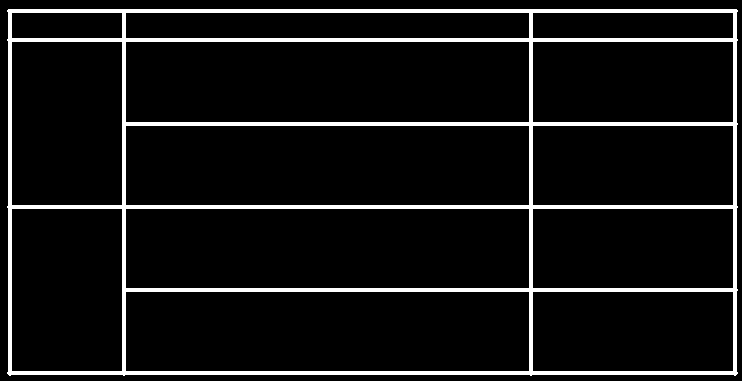

In [10]:
ifa(candidate_grid)

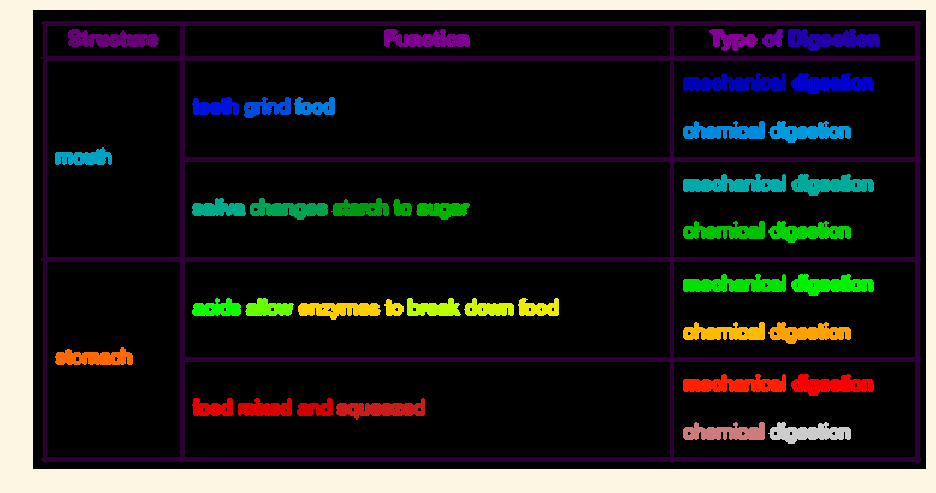

In [11]:
ifb(connected_components)

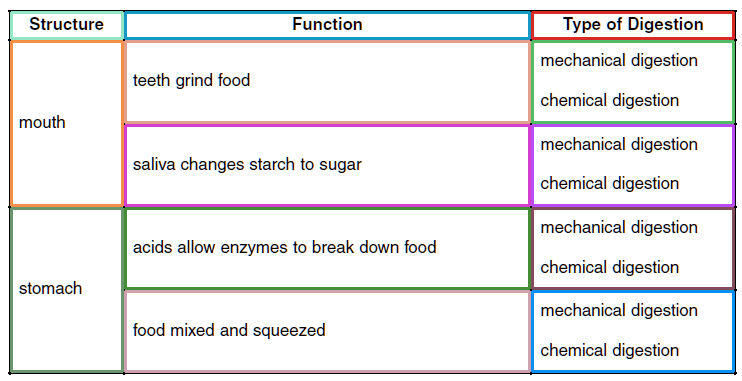

In [12]:
draw_detections(another_image, bounding_boxes)

# Conclusions

## Key findings

* Key finding 1

## Next steps

* Next steps 1